In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark")
import matplotlib.pyplot as plt
%matplotlib inline

## Analysing

In [16]:
load_data = pd.read_csv('train.csv')
print("Data contains {} rows with {} columns".format(load_data.shape[0], load_data.shape[1]))
print("Data contains {} duplicates".format(load_data.duplicated().sum()))
load_data.head()

Data contains 346 rows with 10 columns
Data contains 0 duplicates


,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [17]:
load_data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
load_data.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


loan_status
PAIDOFF       260
COLLECTION     86
Name: count, dtype: int64


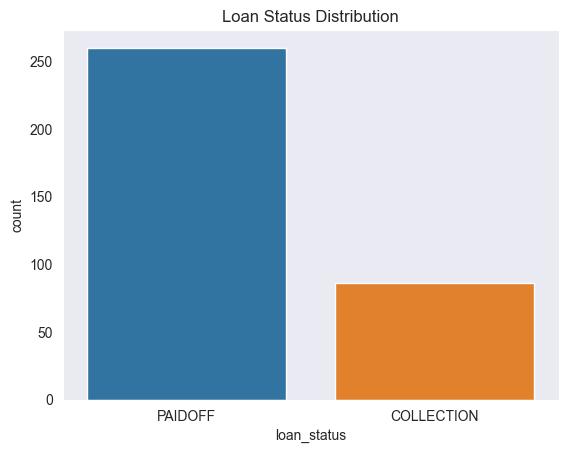

In [18]:
print(load_data.loan_status.value_counts())
ax = sns.countplot(x="loan_status", data=load_data)
ax.set_title("Loan Status Distribution")
plt.savefig('loan_status distribution.pdf')
plt.show()

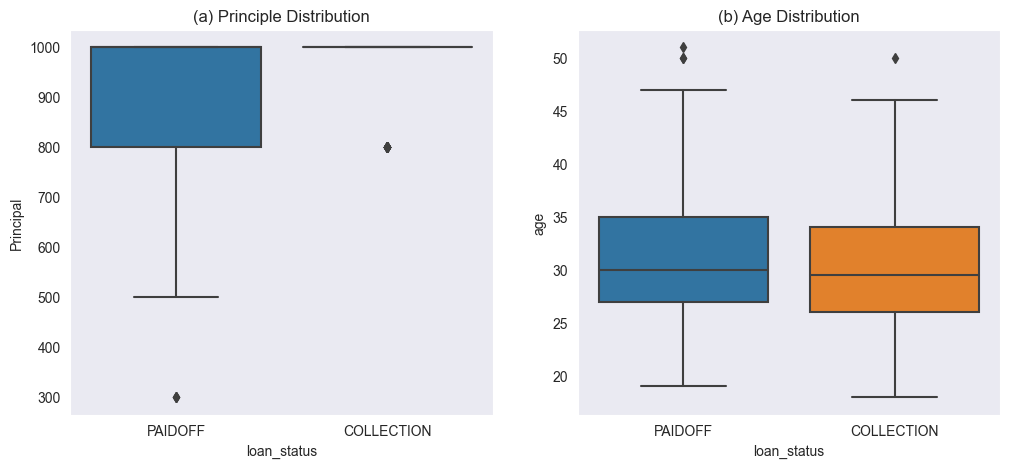

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="loan_status", y="Principal", data=load_data, ax=axs[0])
axs[0].set_title("(a) Principle Distribution")
sns.boxplot(x="loan_status", y="age", data=load_data, ax=axs[1])
axs[1].set_title("(b) Age Distribution")
plt.show()
fig.savefig('Principle&Age Distribution.pdf')

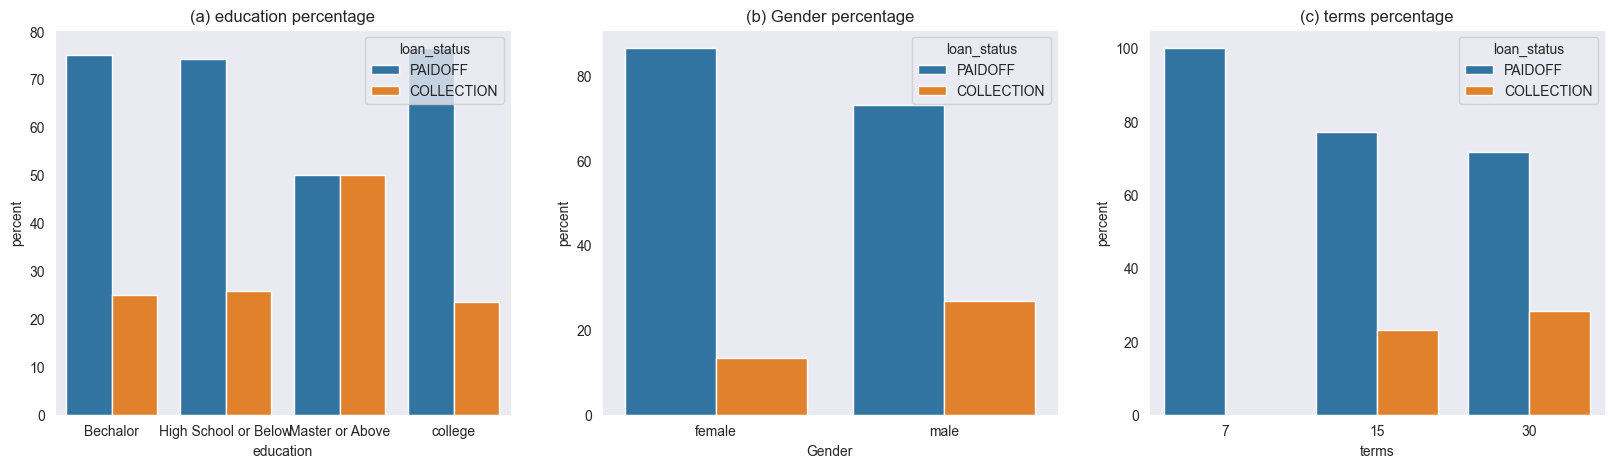

In [25]:
# plot load_status proportion in education, Gender and terms.
columns = ["education", "Gender", "terms"]
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i,col in enumerate(columns):
    (load_data
    .groupby(col)["loan_status"]
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.barplot,'data'), x=col, y='percent',hue="loan_status",ax=axs[i]))
    
    axs[i].set_title("({}) {} percentage".format(chr(97+i),col))
    
fig.savefig('loan_status percentage in education, Gender and terms.pdf',dpi = 600)


## Preprocessing

In [7]:
for col in ["effective_date", "due_date"]:
    load_data[col] = pd.to_datetime(load_data[col])
    load_data[col + "_day"] = load_data[col].dt.dayofweek
    load_data[col + "_month"] = load_data[col].dt.month
    load_data[col + "_year"] = load_data[col].dt.year

load_data.drop(["effective_date", "due_date"], axis=1, inplace=True)
load_data.head()
print(load_data.effective_date_year.value_counts())
print(load_data.due_date_year.value_counts())


effective_date_year
2016    346
Name: count, dtype: int64
due_date_year
2016    346
Name: count, dtype: int64


In [8]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
load_data.drop(["effective_date_year", "due_date_year"], axis=1, inplace=True)
load_data.Gender = load_data.Gender.apply(lambda x: 1 if x == "female" else 0)
enc = OrdinalEncoder()
load_data.education = enc.fit_transform(load_data.education.values.reshape(-1, 1))
le = LabelEncoder()
load_data.loan_status = le.fit_transform(load_data.loan_status)
load_data.info
load_data.head()

,loan_status,Principal,terms,age,education,Gender,effective_date_day,effective_date_month,due_date_day,due_date_month
0,1,1000,30,45,1.0,0,3,9,4,10
1,1,1000,30,33,0.0,1,3,9,4,10
2,1,1000,15,27,3.0,0,3,9,3,9
3,1,1000,30,28,3.0,1,4,9,5,10
4,1,1000,30,29,3.0,0,4,9,5,10


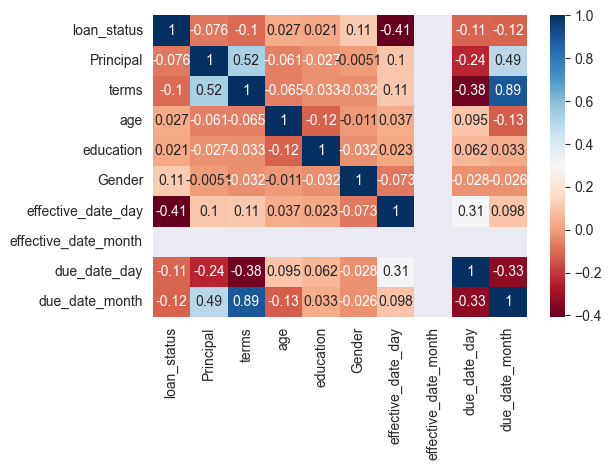

In [9]:
corr = load_data.corr()
sns.heatmap(corr, cmap = "RdBu", annot = True)
plt.tight_layout()
plt.savefig('heatmap of correlation.pdf',dpi = 600)
plt.show()

In [10]:
load_data.drop(["effective_date_month"], axis=1, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = load_data.loan_status.copy()
X = load_data.drop("loan_status", axis=1).copy()
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=765)

## Training

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

## Testing 

In [12]:
print("Decision Tree")
print("Accuracy: ", accuracy_score(y_test, model.predict(X_test)))
print("F1 Score: ", f1_score(y_test, model.predict(X_test)))
print("Confusion Matrix: \n", confusion_matrix(y_test, model.predict(X_test)))
print("Classification Report: \n", classification_report(y_test, model.predict(X_test)))


Decision Tree
Accuracy:  0.7285714285714285
F1 Score:  0.8190476190476189
Confusion Matrix: 
 [[ 8 11]
 [ 8 43]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.42      0.46        19
           1       0.80      0.84      0.82        51

    accuracy                           0.73        70
   macro avg       0.65      0.63      0.64        70
weighted avg       0.72      0.73      0.72        70



## Validation

In [13]:
load_data = pd.read_csv('test.csv')
load_data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
for col in ["effective_date", "due_date"]:
    load_data[col] = pd.to_datetime(load_data[col])
    load_data[col + "_day"] = load_data[col].dt.dayofweek
    load_data[col + "_month"] = load_data[col].dt.month
    load_data[col + "_year"] = load_data[col].dt.year

load_data.drop(["effective_date", "due_date","effective_date_year", "due_date_year", "effective_date_month"], axis=1, inplace=True)
load_data.Gender = load_data.Gender.apply(lambda x: 1 if x == "female" else 0)
enc = OrdinalEncoder()
load_data.education = enc.fit_transform(load_data.education.values.reshape(-1, 1))
load_data = pd.DataFrame(ss.fit_transform(load_data), columns=load_data.columns)
load_data.info
load_data.head()

,Principal,terms,age,education,Gender,effective_date_day,effective_date_month,due_date_day,due_date_month
0,0.493626,0.928450,3.059819,-1.503663,1.977142,-0.286740,0.0,0.298162,0.658505
1,-3.562691,-1.704277,0.533363,0.223950,-0.505781,0.100359,0.0,-0.114678,-1.034793
2,0.493626,0.928450,1.880806,-0.639857,1.977142,0.487458,0.0,1.123841,0.658505
3,0.493626,0.928450,-0.982511,1.087756,-0.505781,0.487458,0.0,1.123841,0.658505
4,-0.665322,-0.788546,-0.477219,-1.503663,-0.505781,0.874558,0.0,1.123841,-1.034793


In [14]:
# output the prediction to txt file
with open('522022330058.txt', 'w') as f:
    #predicts = model.predict(load_data)
    results = le.inverse_transform(model.predict(load_data))
    for result in results:
        f.write(result + "\n")